## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split

import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub 

## Data Collection

In [2]:
normal_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Normal"
stroke_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Stroke"

In [3]:
normal_folder = os.listdir(normal_path)
stroke_folder = os.listdir(stroke_path)

In [4]:
print("Images in Normal Data:",len(normal_folder))
print("Images in Stroke Data:",len(stroke_folder))

Images in Normal Data: 1551
Images in Stroke Data: 950


## Image Data Preprocessing 

In [5]:
normal_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Normal"
stroke_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Stroke"

data = []

for img_file in normal_folder:
    image = Image.open("/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Normal/" + img_file)
    image = image.resize((256,256))
    image = image.convert('RGB')
    image = np.array(image)
    data.append(image)
    
for img_file in stroke_folder:
    image = Image.open("/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Stroke/" + img_file)
    image = image.resize((256,256))
    image = image.convert('RGB')
    image = np.array(image)
    data.append(image)

In [6]:
len(data)

2501

In [7]:
data[0].shape

(256, 256, 3)

In [8]:
data[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

## Class Labels

In [9]:
normal_label = [0]*len(normal_folder)
stroke_label = [1]*len(stroke_folder)

In [10]:
Target_label = normal_label + stroke_label

In [11]:
len(Target_label)

2501

## Convert Image data and target labels into array

In [12]:
x = np.array(data)
y = np.array(Target_label)

In [13]:
x[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [14]:
y

array([0, 0, 0, ..., 1, 1, 1])

## Split The Data for training and testing purpose

In [15]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15,shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2125, 256, 256, 3)
(376, 256, 256, 3)
(2125,)
(376,)


## Scale The Data

In [16]:
x_train_s = x_train/255
x_test_s = x_test/255

## Image Data Visualization

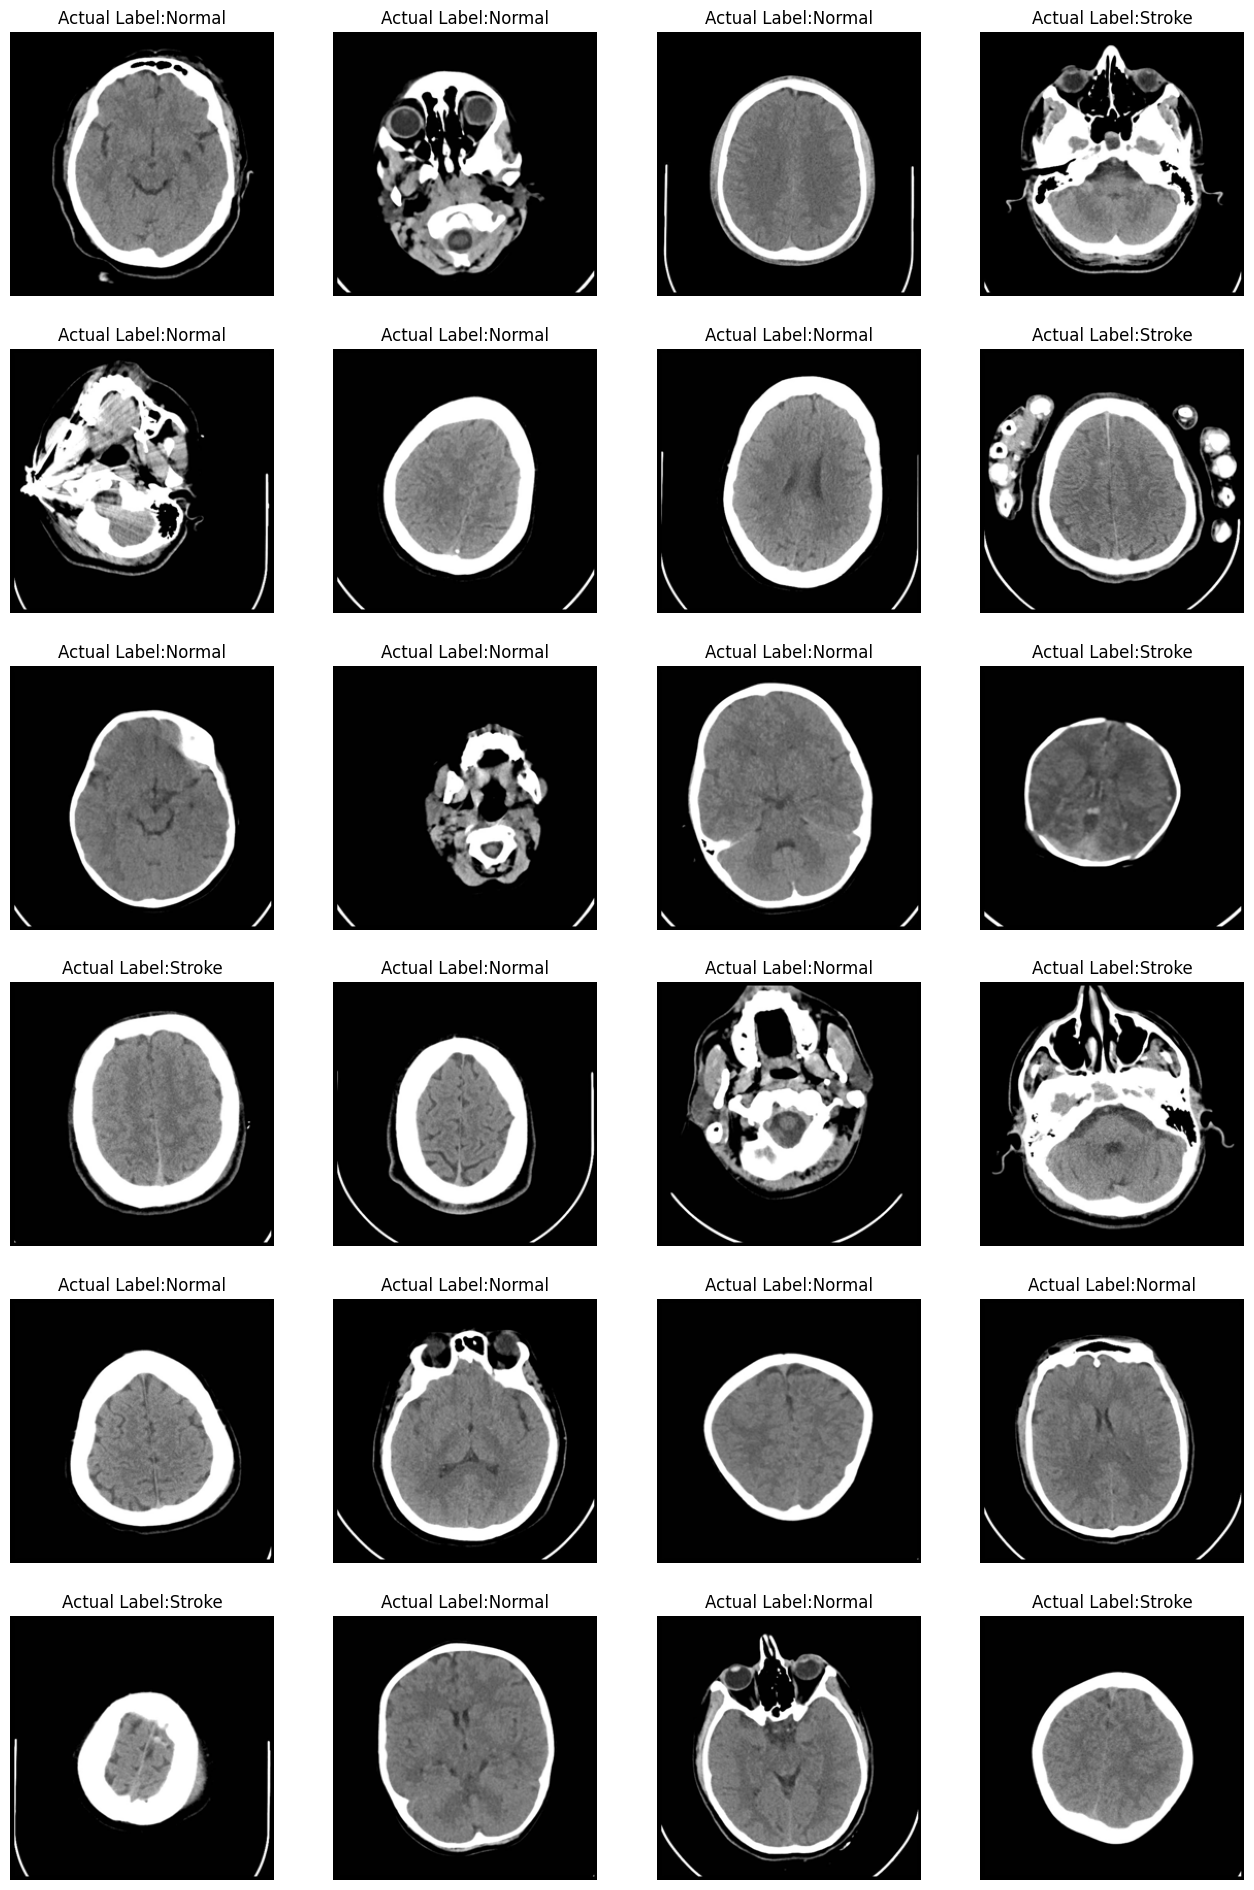

In [17]:
class_labels = ["Normal","Stroke"]
plt.figure(figsize=(16,24))
for i in range(24):
    plt.subplot(6,4,i+1)
    plt.imshow(x_train[i])
    plt.title(f"Actual Label:{class_labels[y_train[i]]}")
    plt.axis("off")

## Create Model Using CNN

In [18]:
model = Sequential()

model.add(Conv2D(filters=100,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=80,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=500, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=500, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",
             metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 80)      72080     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 80)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        46144     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [19]:
history = model.fit(x_train_s,y_train,batch_size=32,
         epochs=12, validation_data=(x_test_s,y_test))

Epoch 1/12
67/67 [==============================] - 443s 7s/step - loss: 0.6247 - accuracy: 0.6631 - val_loss: 0.3730 - val_accuracy: 0.8165
Epoch 2/12
67/67 [==============================] - 472s 7s/step - loss: 0.1945 - accuracy: 0.9200 - val_loss: 0.1072 - val_accuracy: 0.9734
Epoch 3/12
67/67 [==============================] - 465s 7s/step - loss: 0.0457 - accuracy: 0.9807 - val_loss: 0.0976 - val_accuracy: 0.9628
Epoch 4/12
67/67 [==============================] - 463s 7s/step - loss: 0.0441 - accuracy: 0.9878 - val_loss: 0.0859 - val_accuracy: 0.9654
Epoch 5/12
67/67 [==============================] - 445s 7s/step - loss: 0.0078 - accuracy: 0.9967 - val_loss: 0.0621 - val_accuracy: 0.9814
Epoch 6/12
67/67 [==============================] - 477s 7s/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0611 - val_accuracy: 0.9867
Epoch 7/12
67/67 [==============================] - 468s 7s/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.1103 - val_accuracy: 0.9814
Epoch 8/12
67

## Model Evaluation on Test and Train Data

In [20]:
loss, acc = model.evaluate(x_test_s,y_test)
print("Loss on Test Data:",loss)
print("Accuracy on Test Data:",acc)

loss, acc = model.evaluate(x_train_s,y_train)
print("Loss on Train Data:",loss)
print("Accuracy on Train Data:",acc)

12/12 [==============================] - 20s 2s/step - loss: 0.0503 - accuracy: 0.9867
Loss on Test Data: 0.0502500981092453
Accuracy on Test Data: 0.9867021441459656
67/67 [==============================] - 136s 2s/step - loss: 5.7836e-06 - accuracy: 1.0000
Loss on Train Data: 5.7836095948005095e-06
Accuracy on Train Data: 1.0


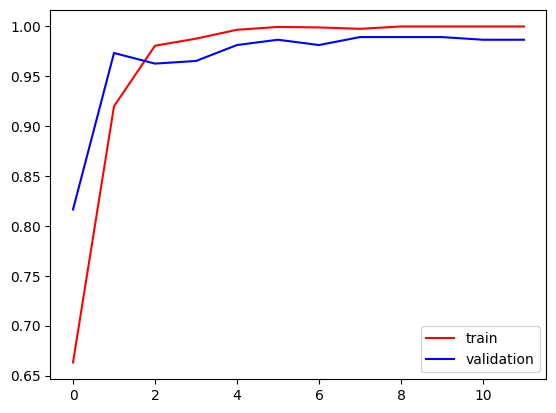

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

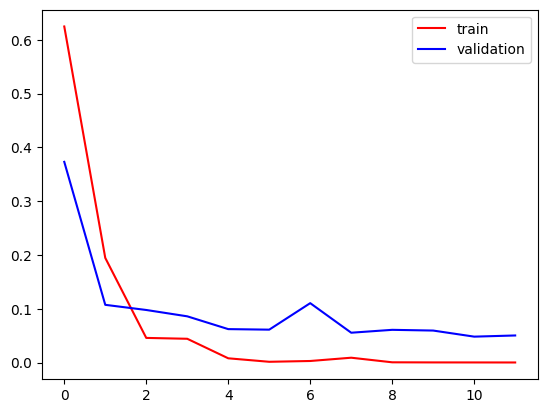

In [22]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

## Predictions on Test Image Data

In [23]:
y_pred_test = model.predict(x_test_s)
y_pred_test_label = [1 if i>=0.5 else 0 for i in y_pred_test]

12/12 [==============================] - 20s 2s/step


In [24]:
print("Actual Label:",y_test[:20])
print("Predicted Label:",y_pred_test_label[:20])

Actual Label: [0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0]
Predicted Label: [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]


## Metrics Evaluation On Test Data

In [25]:
print("-----Metrics Evaluation On Test Data -----")
print()
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred_test_label))
print()
print("Classification Report:\n",classification_report(y_test,y_pred_test_label))

-----Metrics Evaluation On Test Data -----

Confusion Matrix:
 [[224   1]
 [  4 147]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       225
           1       0.99      0.97      0.98       151

    accuracy                           0.99       376
   macro avg       0.99      0.98      0.99       376
weighted avg       0.99      0.99      0.99       376



## ROC - Curve

In [26]:

from sklearn.metrics import roc_curve, precision_recall_curve, auc

y_prob = model.predict(x_test_s)

fpr, tpr, threshold = roc_curve(y_test, y_prob)

# Compute ROC curve and ROC area
roc_auc = auc(fpr, tpr)
print(f"ROC - Area :{roc_auc}")

12/12 [==============================] - 20s 2s/step
ROC - Area :0.999028697571744


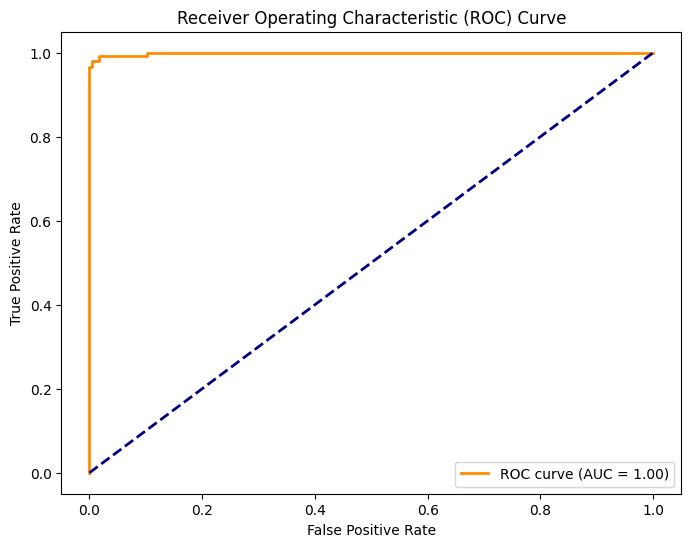

In [27]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## PR Curve

In [28]:
y_prob = model.predict(x_test_s)

precision, recall, threshold = precision_recall_curve(y_test, y_prob)

# Compute ROC curve and ROC area
pr_auc = auc(recall,precision)
print(f"PR - Area :{pr_auc}")

12/12 [==============================] - 19s 2s/step
PR - Area :0.998686301569306


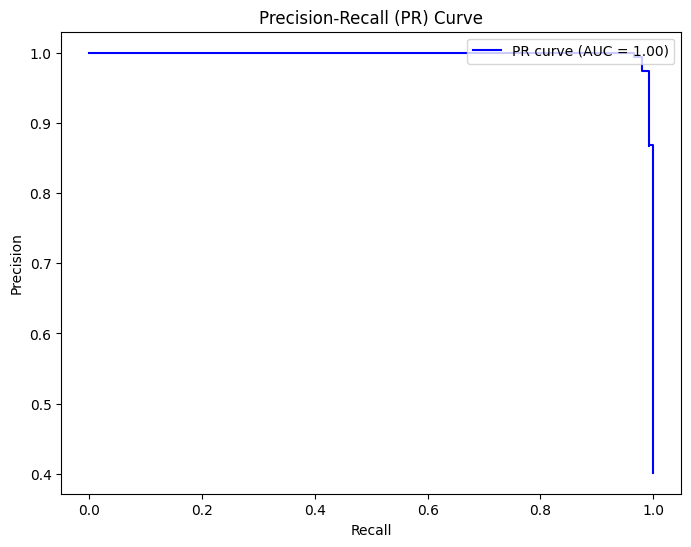

In [29]:
# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post', label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='upper right')
plt.show()

## Image Predictions on Test Data

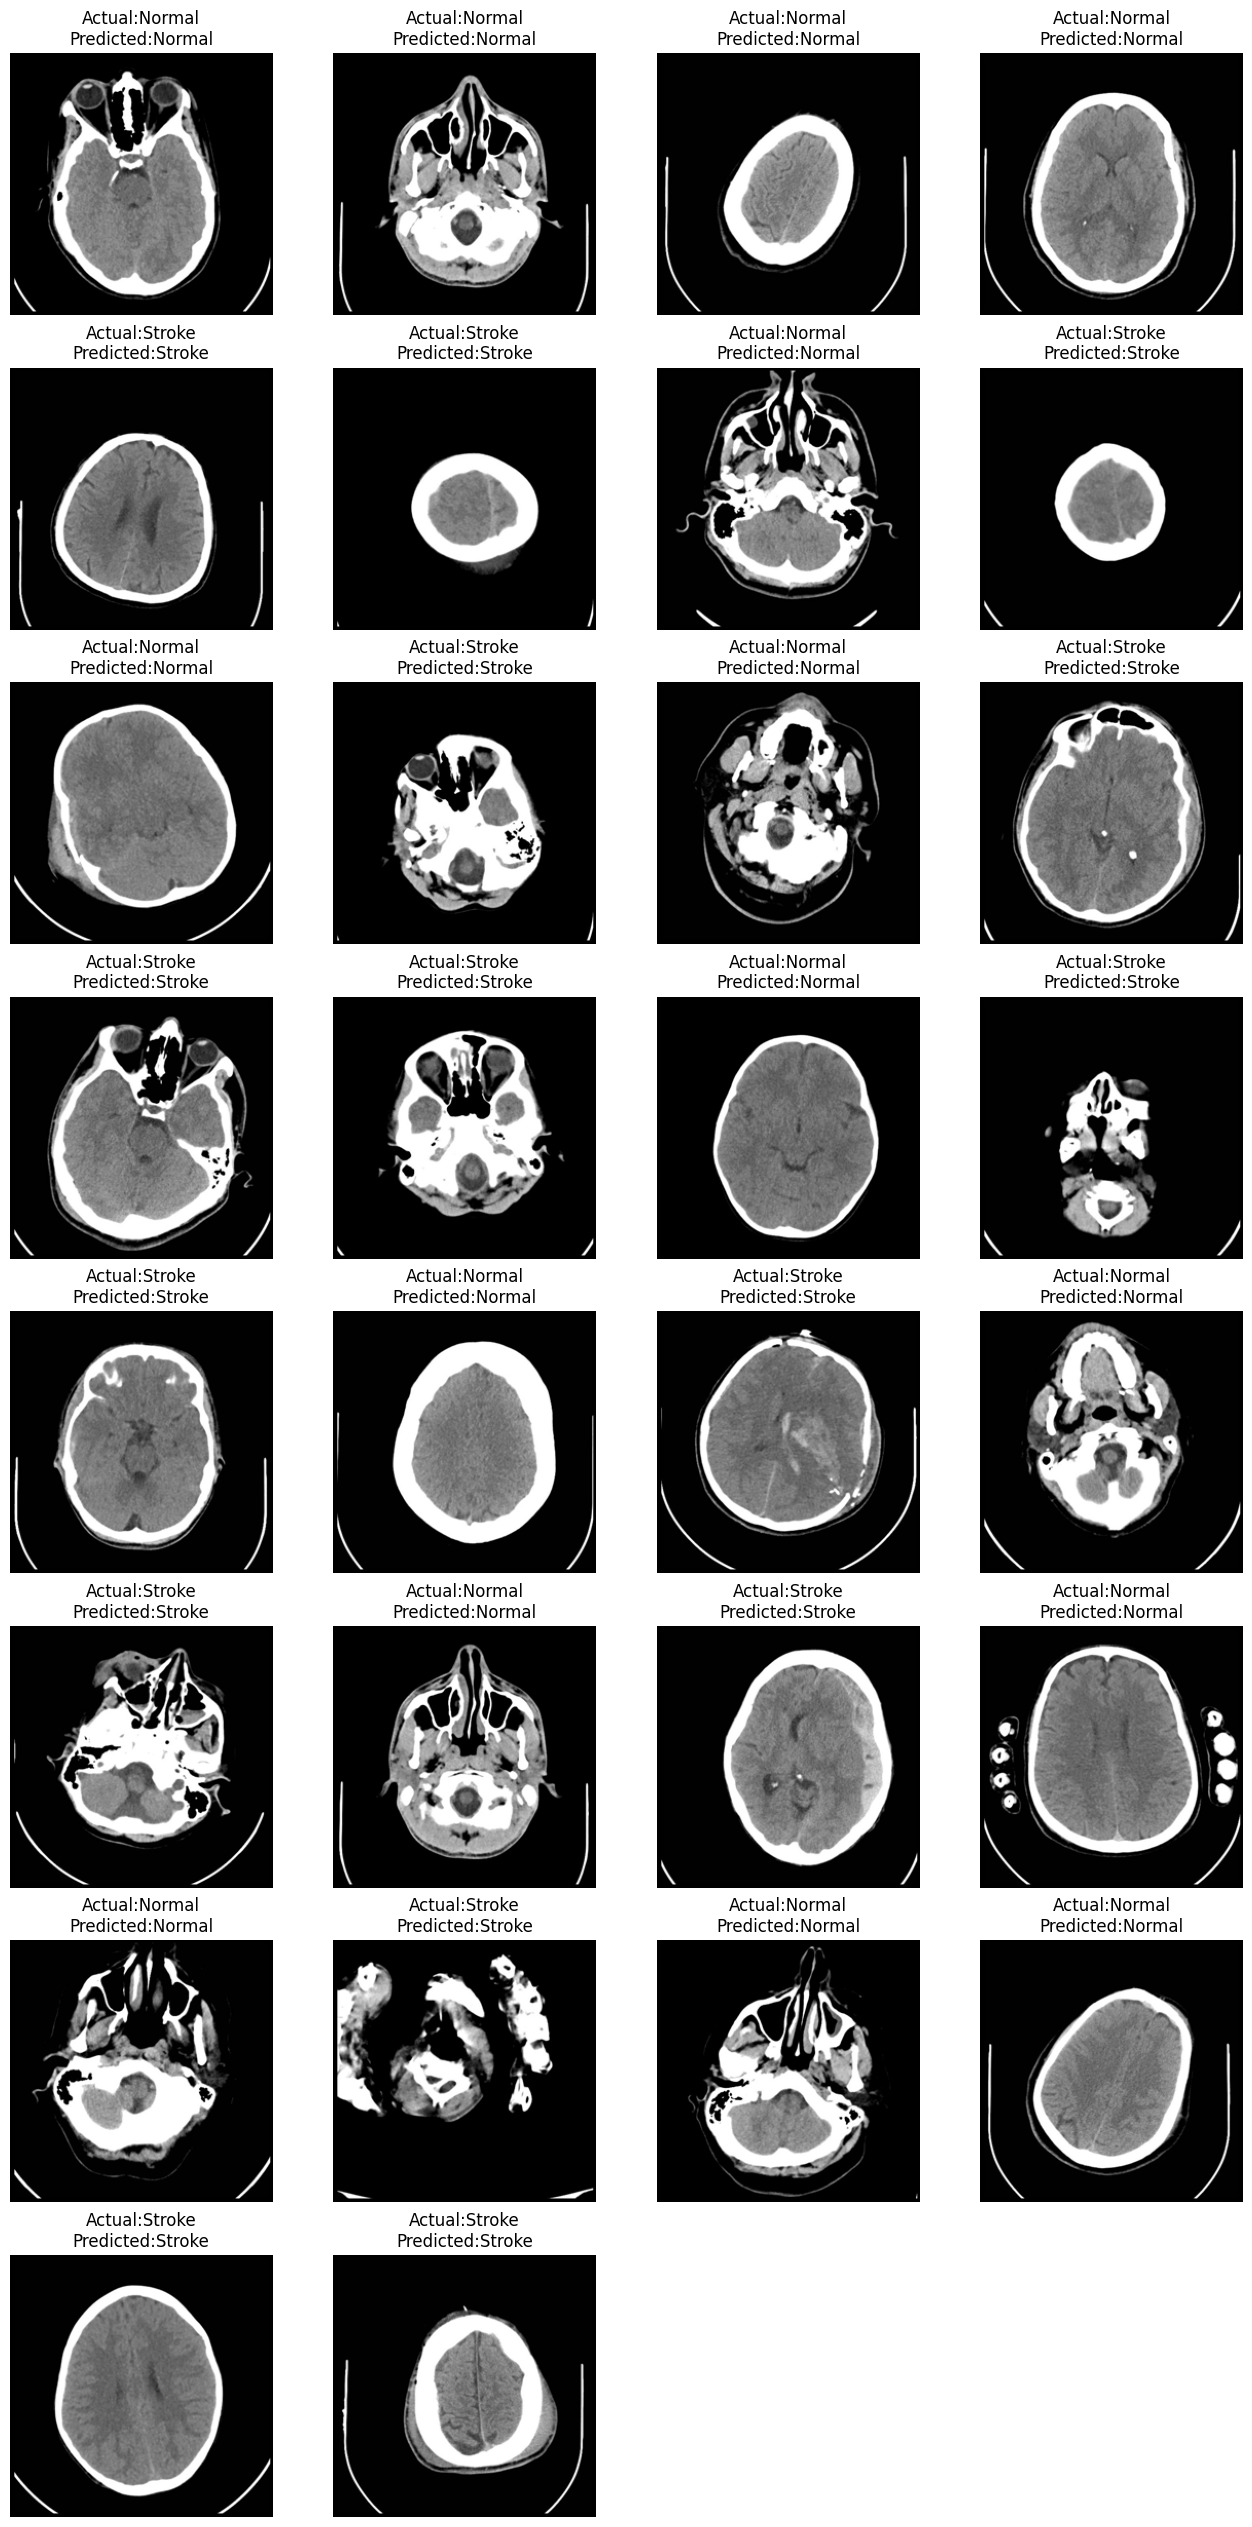

In [30]:
class_labels = ["Normal","Stroke"]
plt.figure(figsize=(16,32))
for i in range(30):
    plt.subplot(8,4,i+1)
    plt.imshow(x_test[i])
    plt.title(f"Actual:{class_labels[y_test[i]]}\nPredicted:{class_labels[y_pred_test_label[i]]}")
    plt.axis("off")

## Result Using CNN :

In [31]:
import cv2

In [32]:
test_img = cv2.imread('/kaggle/input/checker/checker-Stroke.jpg')

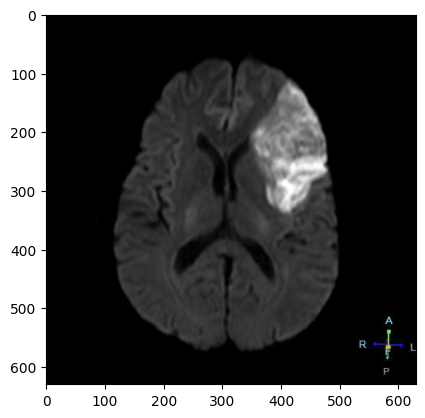

In [33]:
plt.imshow(test_img)

In [34]:
test_img = cv2.resize(test_img,(256,256))

In [35]:
test_input = test_img.reshape((1,256,256,3))

In [36]:
model.predict(test_input)

1/1 [==============================] - 0s 176ms/step


array([[0.]], dtype=float32)